<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Автор: [Yury Kashnitsky](https://yorko.github.io). Все материалы распространяются под [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).


# Задание #10 
## Реализация алгоритма градиентного бустинга


В этом задании мы рассмотрим и реализуем алгоритм градиентного усиления в достаточно общем виде: в одном классе будет реализован бинарный классификатор, минимизирующий логистическую функцию потерь, и два регрессора, минимизирующие среднюю квадратичную ошибку (MSE) и среднеквадратичную логарифмическую ошибку ([RMSLE](http://web.archive.org/web/20170913132944/https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError)). Таким образом, мы увидим, что с помощью градиентного усиления можно оптимизировать произвольные дифференцируемые функции и как эта техника адаптируется к различным условиям.

### Задача состоит в том, чтобы:
 1. написать код и выполнить вычисления в ячейках ниже;
 2. выбрать ответы в [веб-форме](https://forms.gle/jcn9ckFS9pXUji668).

*Если вы уверены, что в задании/решении что-то не на 100% верно, пожалуйста, оставьте свой отзыв через указанную веб-форму ↑*

-----

Мы будем использовать вариант алгоритма из [статьи](https://mlcourse.ai/book/topic10/topic10_gradient_boosting.html#friedman-s-classic-gbm-algorithm), но с двумя упрощениями:
1. Мы инициализируем алгоритм средним значением вектора $\large y$, т.е. $\large \hat{f_0} = \frac{1}{n}\sum_{i=1}^{n}y_i$.
2. Скорость обучения сделаем постоянной: $\large \rho_t = const$.

В `GradientBoosting` существует соответствие между псевдокодом и параметрами класса:

| What | Pseudo code &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;| `GradientBoosting` |
|:-----|:--------------------------------------|:-------------------|
| Training set  | $\large \{x_i, y_i\}_{i = 1,\ldots n}$ | `X`, `y` |
| Loss function | $\large L(y,f)$ | `objective` |
| Loss function gradient | $\large \frac{\partial L(y_i,f(x_i))}{\partial f(x_i)}$ | `objective_grad` |
| Number of iterations | $\large М$ | `n_estimators` |
| Base algorithm (decision tree regressor) | $\large h(x,\theta)$ | `DecisionionTreeRegressor` |
| Decision tree hyperparameters | $\large \theta$ | We will use only `max_depth` and `random_state`. |
| Learning rate<br>(coefficient for $\large h_t(x,\theta)$ in the composition) | $\large \rho_t, \quad t=1,\ldots,M$ | `learning_rate` |

## Вывод градиентов для log_loss, MSE и RMSLE

Начнем с традиционного способа выведения формул с помощью ручки и бумаги:
$\DeclareMathOperator{\logloss}{log\_loss}$
$\DeclareMathOperator{\MSE}{MSE}$
$\DeclareMathOperator{\RMSLE}{RMSLE}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\p}{\mathbf{p}}$

$$\begin{array}{rcl}
\logloss(\y, \p) &=& -\y\log \p + (1 - \y)\log (1 - \p) \\
&=& -\sum_{i=1}^{n}\left[y_i\log p_i + (1 - y_i)\log (1 - p_i)\right] \\
\\
\MSE(\y, \p) &=& \frac{1}{n}(\y - \p)^T(\y - \p) = \frac{1}{n}\sum_{i=1}^{n}(y_i - p_i)^2 \\
\\
\RMSLE(\y, \p) &=& \sqrt{\frac{1}{n} (\log (\p + 1) - \log (\y + 1))^T(\log (\p + 1) - \log (\y + 1))} \\
&=& \sqrt{\frac{1}{n} \sum_{i=1}^{n}(\log (p_i + 1) - \log (y_i + 1))^2}
\end{array}$$

где:

* $\y$ и $\p$ - это **векторы** значений и прогнозов соответственно.
* $\logloss$ принимает те же значения, что и в `scikit-learn`, с $0$ и $1$ вместо $-1$ и $1$, как описано в основной статье.

**Вопрос 1. Каково выражение для градиента `MSE`?**

$\begin{array}{rcl}
&& \text{1. } (\p - \y) && \text{3. } 2(\p - \y) \\
&& \text{2. } \frac{2}{n}(\y - \p) && \text{4. } \frac{2}{n}(\p - \y)
\end{array}$

**Решение:**

$\large \frac{\partial}{\partial p_i} \MSE = \frac{1}{n} \cdot 2(y_i - p_i) \cdot (-1) = \frac{2}{n}
(p_i - y_i)$

Тогда
$\large \nabla \MSE = \frac{2}{n}(\p - \y)$

**Ответ:**

$\text{4. }\large \frac{2}{n}(\p - \y)$

**Вопрос 2. Каково выражение для градиента `log_loss`?**

$\begin{array}{rcl}
&& \text{1. } \large \frac{\y - \p}{\y(1 - \y)} && \text{3. } \large \frac{\p - \y}{\p(1 - \p)} \\
&& \text{2. } \large \frac{\y - \p}{\p(1 - \p)} && \text{4. } \large \frac{\p - \y}{\y(1 - \y)}
\end{array}$

*Примечание:* деление на вектор происходит поэлементно, т.е. $\large \frac{1}{\p} = (\frac{1}{p_1}, \ldots \frac{1}{p_n})^T$.

**Решение:**

$\large \frac{\partial}{\partial p_i} \logloss = y_i \cdot \frac{1}{p_i} + (1 - y_i) \cdot \frac{1}{1 - p_i} \cdot (-1) = \frac{y_i}{p_i} - \frac{1 - y_i}{1 - p_i} = \frac{y_i(1 - p_i) - p_i(1 - y_i)}{p_i(1 - p_i)} = \frac{y_i - y_ip_i - p_i + p_iy_i}{p_i(1 - p_i)} = \frac{y_i - p_i}{p_i(1 - p_i)}$

Тогда
$\large \nabla \logloss = \frac{\y - \p}{\p(1 - \p)}$

**Ответ:**

$\text{2. }\large \frac{\y - \p}{\p(1 - \p)}$

**Вопрос 3. Каково выражение для градиента `RMSLE`?**

$\begin{array}{rcl}
&& \text{1. } \frac{1}{n}(\p + 1)\RMSLE^{-1}(\y, \p) \log \frac{\p+1}{\y+1} && \text{3. } [n(\y + 1)\RMSLE(\y, \p)]^{-1} \log \frac{\p+1}{\y+1} \\
&& \text{2. } [n(\p + 1)\RMSLE(\y, \p)]^{-1} \log \frac{\p+1}{\y+1} && \text{4. } \frac{1}{n}\frac{\y+1}{(\p + 1)}\RMSLE^{-1}(\y, \p) \log \frac{\p+1}{\y+1}
\end{array}$

**Решение:**

$\large \frac{\partial}{\partial p_i} \RMSLE = \frac{1}{2 \cdot \RMSLE} \left( \frac{1}{n} \cdot 2(\log(p_i + 1) - \log(y_i + 1)) \cdot \frac{1}{p_i + 1} \right) = \frac{1}{n \cdot \RMSLE \cdot (p_i + 1)} \cdot (\log(p_i + 1) - \log(y_i + 1)) = \left[n \cdot (p_i + 1) \cdot \RMSLE \right]^{-1} \cdot \log{\frac{p_i + 1}{y_i + 1}}$

Тогда $\large \nabla \RMSLE = \left[n \cdot (\p + 1) \cdot \RMSLE \right]^{-1} \cdot \log{\frac{\p + 1}{\y + 1}}$

**Ответ:**

$\text{2. } \large [n(\p + 1)\RMSLE(\y, \p)]^{-1} \log \frac{\p+1}{\y+1}$

## Реализация алгоритма

**Задание:**

Реализуйте класс `GradientBoosting`, используя следующую спецификацию:
- Класс наследуется от `sklearn.base.BaseEstimator`.
- Конструктор имеет следующие параметры:

     - `loss` - оптимизируемая функция потерь: `log_loss`, `mse` (по умолчанию) или `rmsle`;
     - `n_estimators` - количество деревьев, то есть количество итераций бустинга (по умолчанию 10);
     - `learning_rate` - скорость обучения (по умолчанию $10^{-2}$);
     - `max_depth` - максимальная глубина дерева (по умолчанию 3);
     - `random_state` - seed для генератора случайных чисел, используется только для деревьев (по умолчанию 17).
     
- В зависимости от значения `loss` по-разному инициализируются `objective` и `objective_grad`:

     - Для `mse` используется `sklearn.metrics.mean_squared_error`;
     - Для `log_loss` используется `sklearn.metrics.log_loss`;
     - Для `rmsle` необходимо самостоятельно реализовать функцию потерь, а также градиенты всех трех функций потерь. Также при вычислении градиентов не следует опускать константы типа $2$ или $n$.

- В реализациях градиентов для `log_loss` и `rmsle` будет использоваться поэлементное деление вектора. Чтобы избежать деления на ноль, замените все значения меньше $10^{-5}$ на $10^{-5}$, но делайте это только там, где это абсолютно необходимо. Например, при вычислении $\frac{y}{p}$ заменяйте только значения в векторе $p$.
- Конструктор должен создавать списки `loss_by_iter_` и `residuals_by_iter_` для отладки и `trees_` для хранения обученных деревьев.
- Класс должен иметь методы `fit`, `predict` и `predict_proba`:
    - Метод `fit` принимает в качестве аргументов матрицу `X` и вектор `y` (оба являются экземплярами `numpy.array`) и возвращает текущий экземпляр `GradientBoosting`, т.е. `self`. В этом методе будет реализована основная логика алгоритма. На каждой итерации текущее значение функции потерь хранится в `loss_by_iter`, значение антиградиента (то, что в статье мы называли *псевдоостатками*) - в `residuals_by_iter_`. Как вариант, можно добавить в аргументы конструктора флаг `debug=False` и хранить значения антиградиента при его установке в `True`. Каждое новое обученное дерево должно храниться в списке `trees_`.
    - Метод `predict_proba` возвращает линейную комбинацию предсказаний по деревьям. Не забудьте про начальное приближение. В случае регрессии название метода несколько вводит в заблуждение, но оставим его, чтобы не пришлось реализовывать его дважды - для регрессора и классификатора. В случае классификации к возвращаемому значению применяется $\sigma$-преобразование. При реализации $\sigma$-функции заменим аргументы с абсолютными значениями больше $100$ на $100$ или $-100$, в зависимости от знака аргумента, чтобы избежать underflow или overflow.
    - В случае регрессии метод `predict` возвращает линейную комбинацию предсказаний по всем деревьям (плюс начальное приближение), т.е. то же самое, что и метод `predict_proba`. В случае классификации `predict` использует `predict_proba` и возвращает вектор, состоящий из $0$-ей и $1$-иц, полученных путем сравнения предсказанных вероятностей с порогом, максимизирующим долю правильных ответов на обучающем множестве. Здесь лучше решать задачу одномерной оптимизации, но для воспроизводимости следует выбрать порог из `np.linspace(0.01, 1.01, 100)`.

**Решение**

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from tqdm.notebook import tqdm

sns.set()
# sharper plots
%config InlineBackend.figure_format = 'retina'

In [2]:
class GradientBoosting(BaseEstimator):
    def __init__(
        self,
        loss_name="mse",
        n_estimators=10,
        learning_rate=0.01,
        max_depth=3,
        random_state=17,
        debug=False
    ):
        self.loss_name = loss_name
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.debug = debug
        
        if self.loss_name == "mse":
            self.objective = mean_squared_error
            self.objective_grad = self.mse_grad
        elif self.loss_name == "log_loss":
            self.objective = self.log_loss
            self.objective_grad = self.log_loss_grad
        elif self.loss_name == "rmsle":
            self.objective = self.rmsle
            self.objective_grad = self.rmsle_grad
        else:
            raise ValueError(f"loss_name (\"{loss_name}\") not in [\"mse\", \"log_loss\", \"rmsle\"]")
            
        self.trees_ = []
        self.loss_by_iter = []

        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0], 1])
        
        if self.debug:
            self.residuals = []
            self.temp_pred = []


    def sigma(self, z):
        z = z.reshape([z.shape[0], 1])
        z[z > 100] = 100
        z[z < -100] = -100
        return 1.0 / (1 + np.exp(-z))


    def log_loss(self, y, p):
        return log_loss(y, p, normalize=False)

    def log_loss_grad(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        p[p < 1e-5] = 1e-5
        p[p > 1 - 1e-5] = 1 - 1e-5
        return (p - y) / p / (1 - p)


    def mse_grad(self, y, p):
        return 2 * (p - y.reshape([y.shape[0], 1])) / y.shape[0]


    def rmsle(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        return np.mean(np.log((p + 1) / (y + 1)) ** 2) ** 0.5


    def rmsle_grad(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        return (
            1.0 / (y.shape[0] * (p + 1) * self.rmsle(y, p)) * np.log((p + 1) / (y + 1))
        )


    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)
        prediction = b.copy()
        
        for t in tqdm(range(self.n_estimators)):
            resid = -self.objective_grad(y, prediction)
            
            if self.debug:
                self.residuals.append(resid)
                
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state
            ).fit(X, resid)
            
            b = tree.predict(X).reshape([X.shape[0], 1])
            
            if self.debug:
                self.temp_pred.append(b)
                
            self.trees_.append(tree)
            
            prediction += self.learning_rate * b
            
            self.loss_by_iter.append(self.objective(y, prediction))
            
        self.train_pred = prediction
        
        if self.loss_name == "log_loss":
            self.train_pred = self.sigma(self.train_pred)
        
        return self


    def predict_proba(self, X):
        pred = np.ones([X.shape[0], 1]) * np.mean(self.y)
        for t in tqdm(range(self.n_estimators)):
            pred += self.learning_rate * self.trees_[t].predict(X).reshape([X.shape[0], 1])
        if self.loss_name == "log_loss":
            return self.sigma(pred)
        else:
            return pred


    def predict(self, X):
        pred_probs = self.predict_proba(X)
        
        if self.loss_name == "log_loss":
            max_accuracy = 0.
            best_thres = 0.
            for thres in tqdm(np.linspace(0.01, 1.01, 100)):
                acc = accuracy_score(self.y, self.train_pred > thres)
                if acc > max_accuracy:
                    max_accuracy = acc
                    best_thres = thres
            return pred_probs > best_thres
        else:
            return pred_probs

In [3]:
def get_1d_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    return np.arange(x_min, x_max, eps)


def get_2d_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps), np.arange(y_min, y_max, eps))

## Регрессия на игрушечном примере

Подготовьте набор данных:

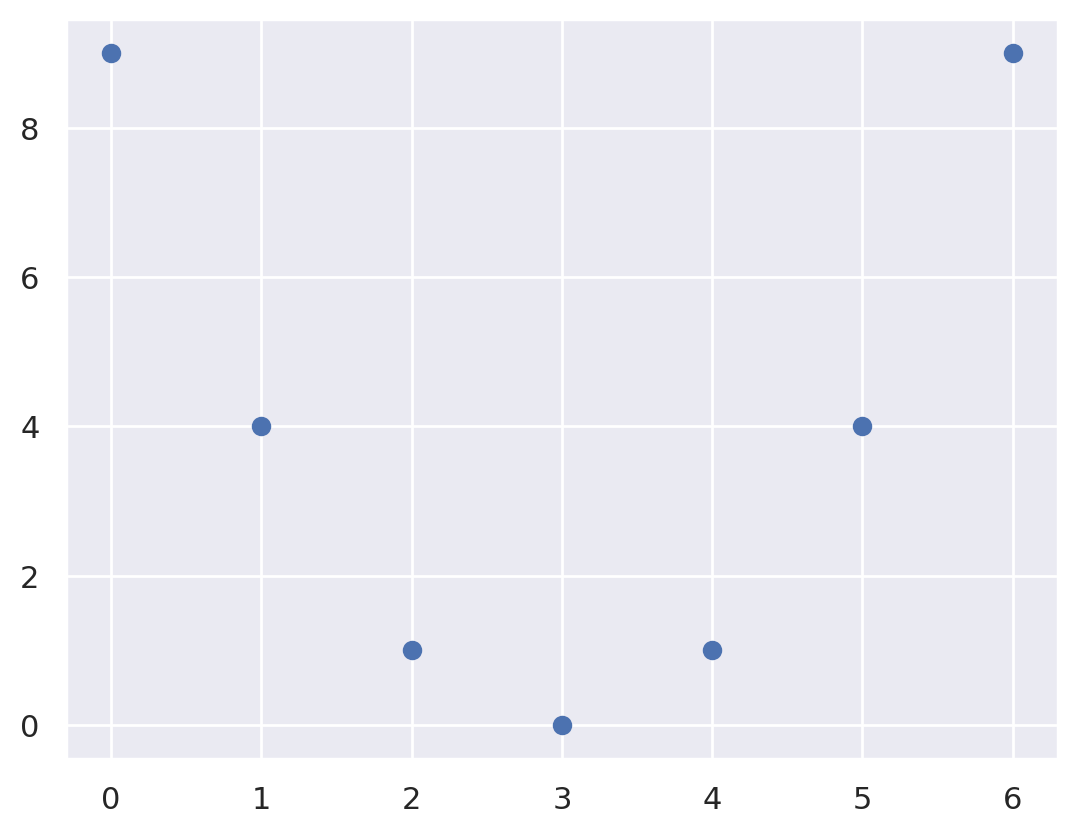

In [4]:
X_regr_toy = np.arange(7).reshape(-1, 1)

y_regr_toy = ((X_regr_toy - 3) ** 2).astype("float64")

plt.scatter(X_regr_toy, y_regr_toy);

**Задание:**

Обучить экземпляр регрессора `GradientBoosting` с функцией потерь `MSE` и следующими входными параметрами: `learning_rate=0.1`, `max_depth=3`, `n_estimators=200`. Затем постройте график изменения функции потерь за итерации бустинга. Можно также визуализировать начальное приближение и псевдоостатки на первых итерациях, как это сделано в статье.

**Решение:**

In [5]:
gbr_mse = GradientBoosting(
    loss_name="mse",
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    debug=True
)
gbr_mse.fit(X_regr_toy, y_regr_toy)

  0%|          | 0/200 [00:00<?, ?it/s]

GradientBoosting(debug=True, learning_rate=0.1, n_estimators=200)

  0%|          | 0/200 [00:00<?, ?it/s]

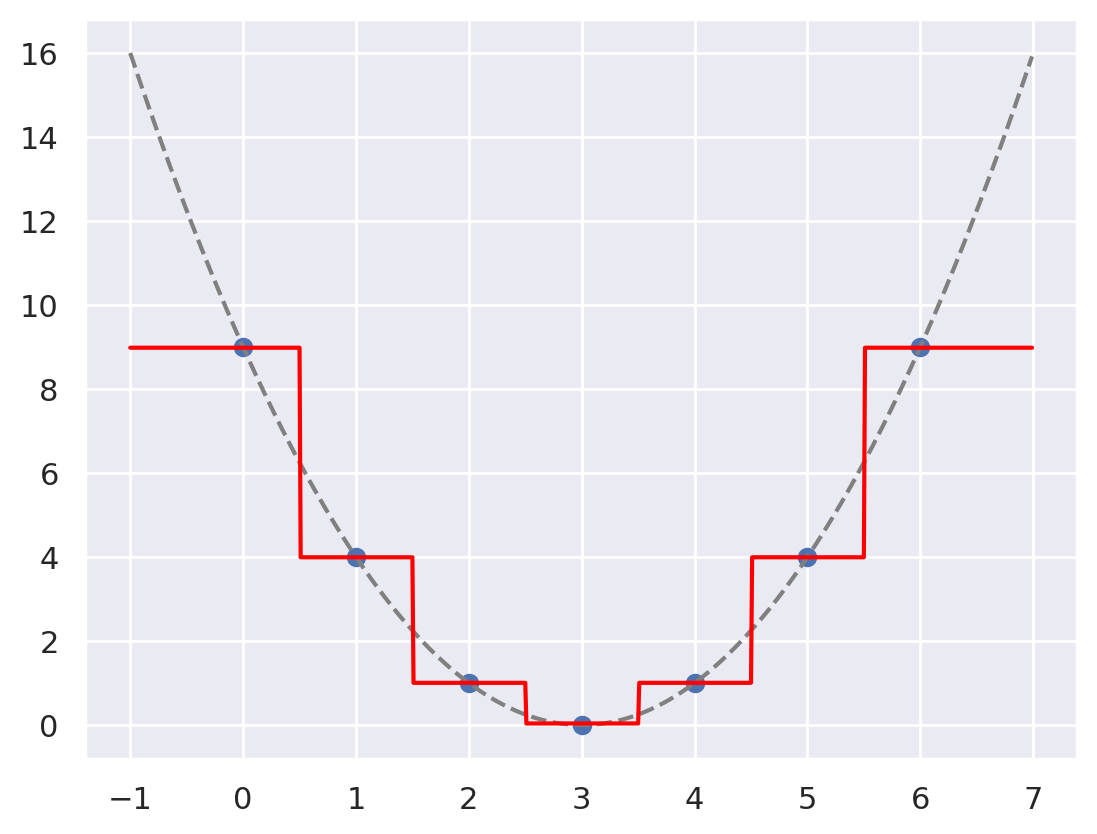

In [6]:
xx = get_1d_grid(X_regr_toy)
plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
plt.scatter(X_regr_toy, y_regr_toy)
plt.plot(xx, gbr_mse.predict(xx.reshape([xx.shape[0], 1])), color="red");

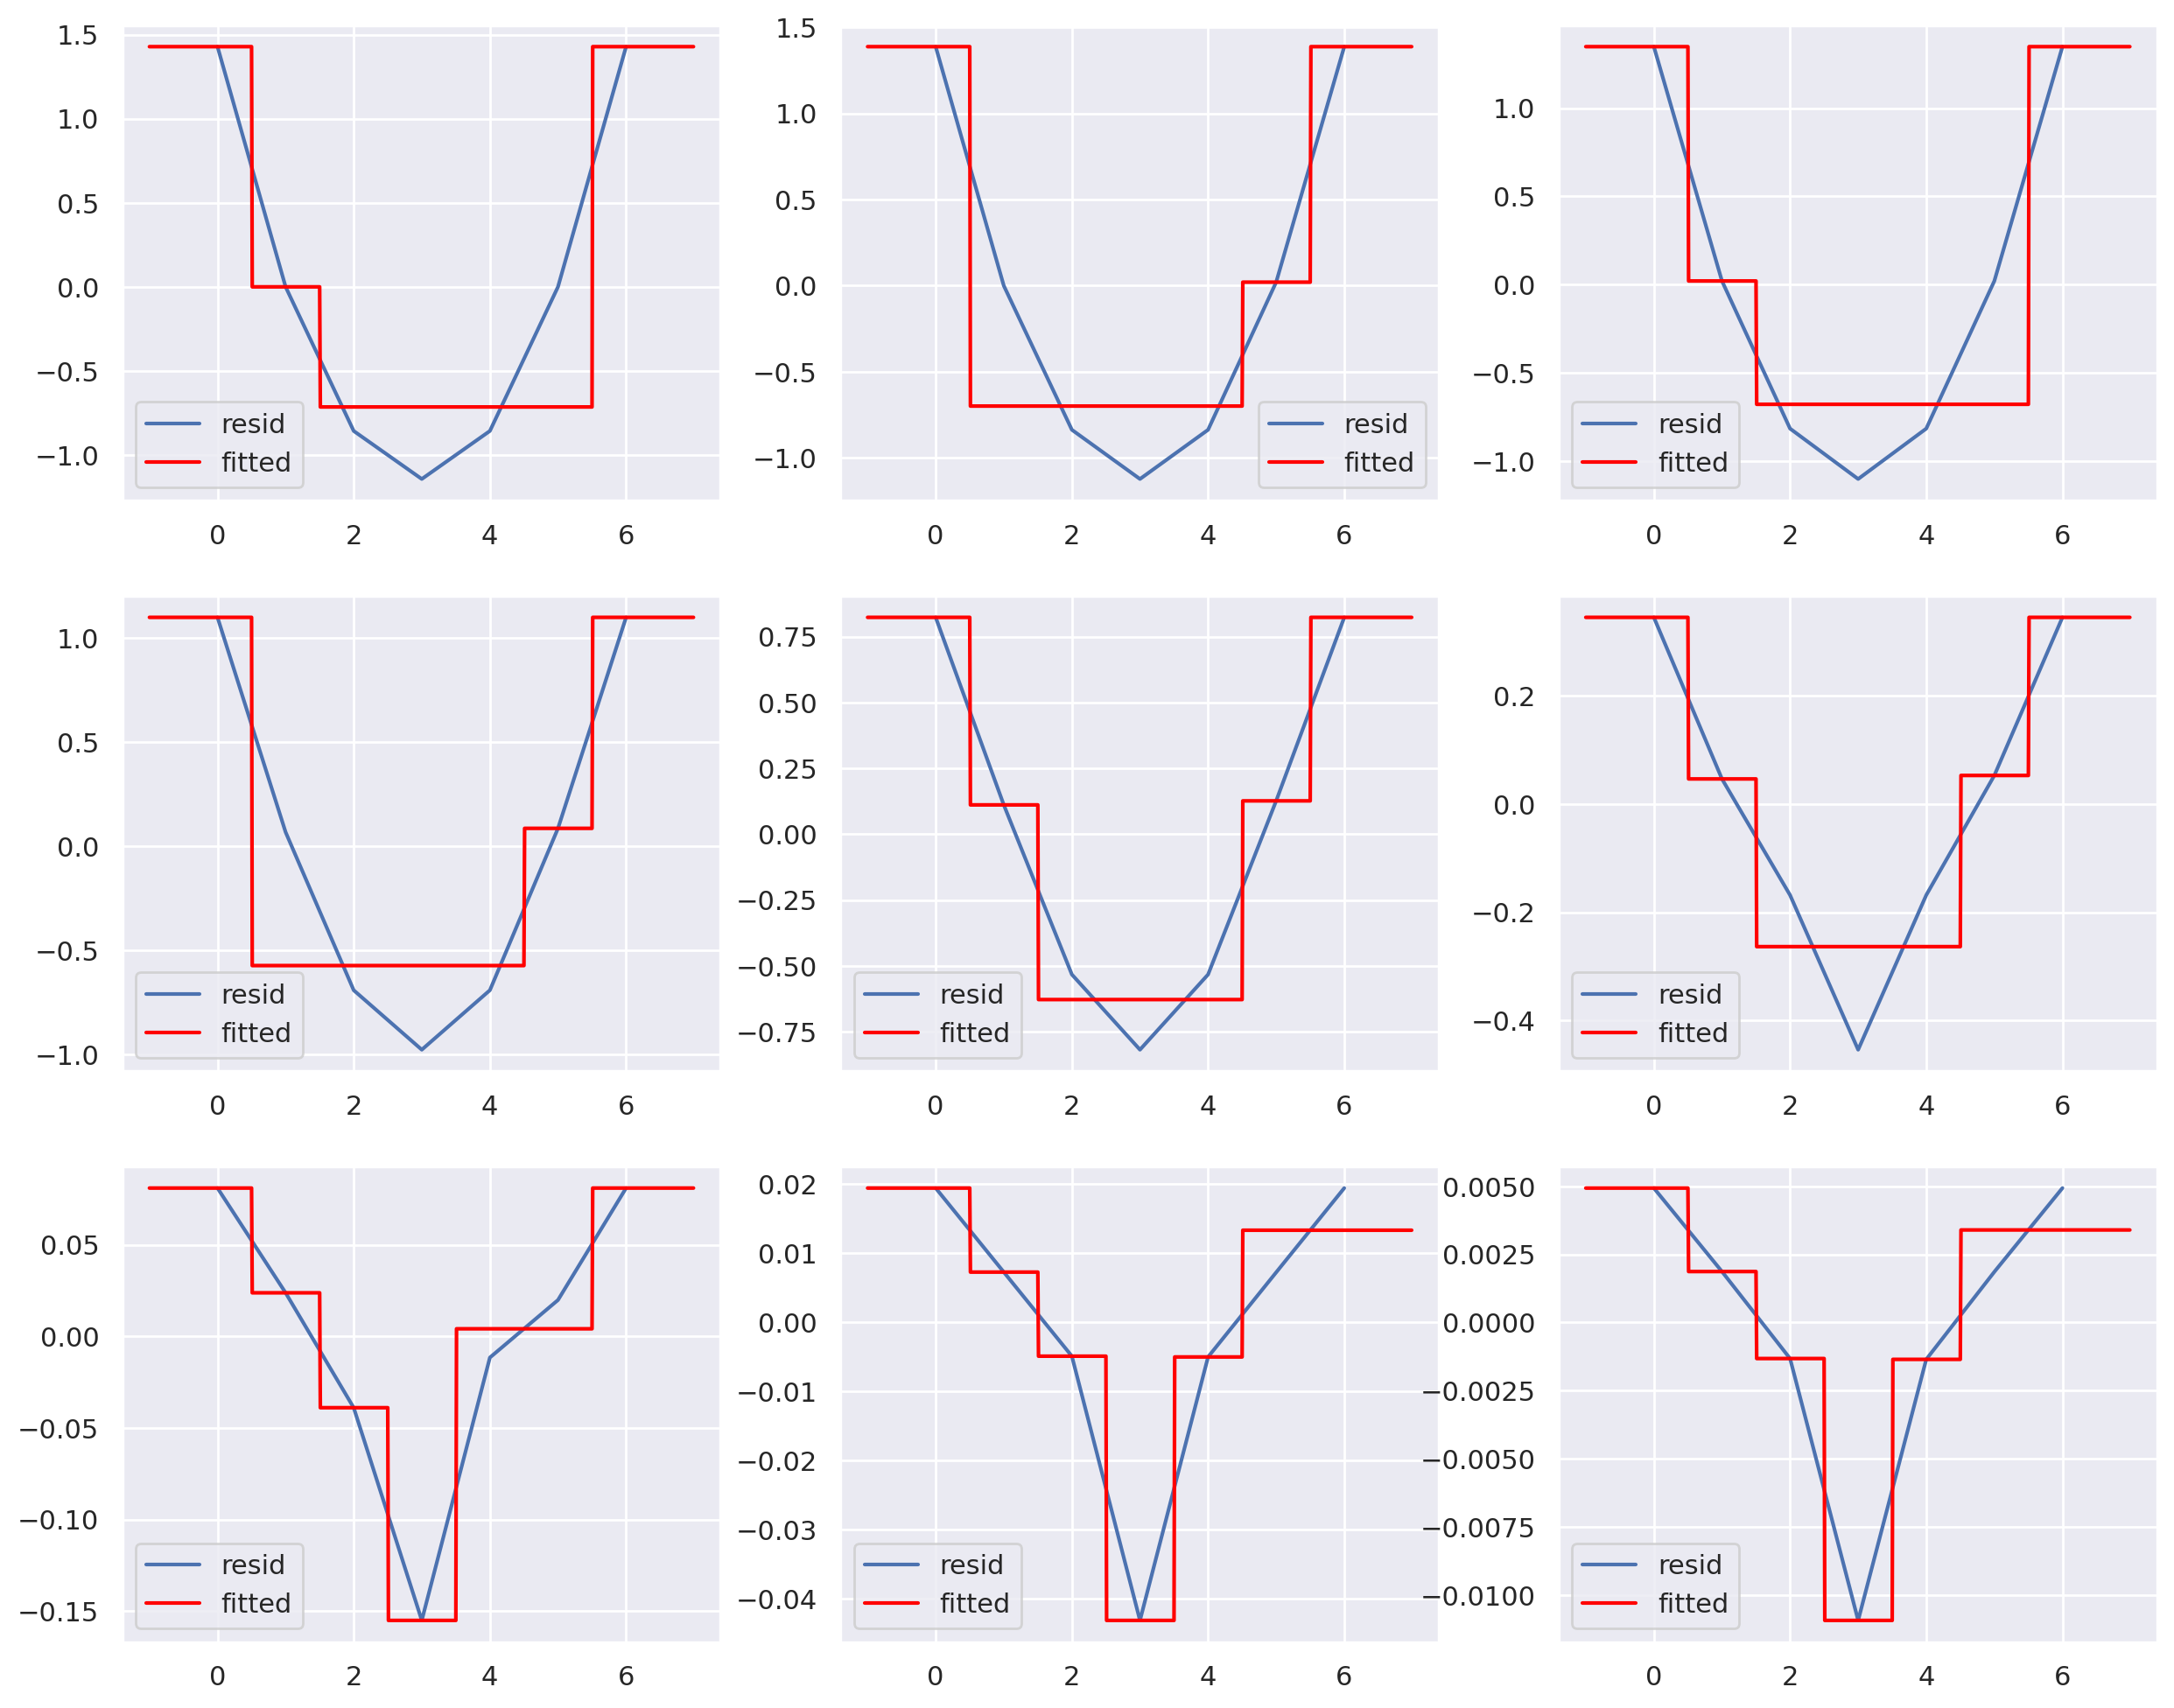

In [7]:
plt.rcParams["figure.figsize"]=(15, 12)

plt.subplots(3, 3)


for i, tree_idx in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    plt.plot(
        X_regr_toy,
        gbr_mse.residuals[tree_idx - 1],
        label="resid"
    )
    plt.plot(
        xx,
        gbr_mse.trees_[tree_idx - 1].predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted"
    )
    plt.legend();

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

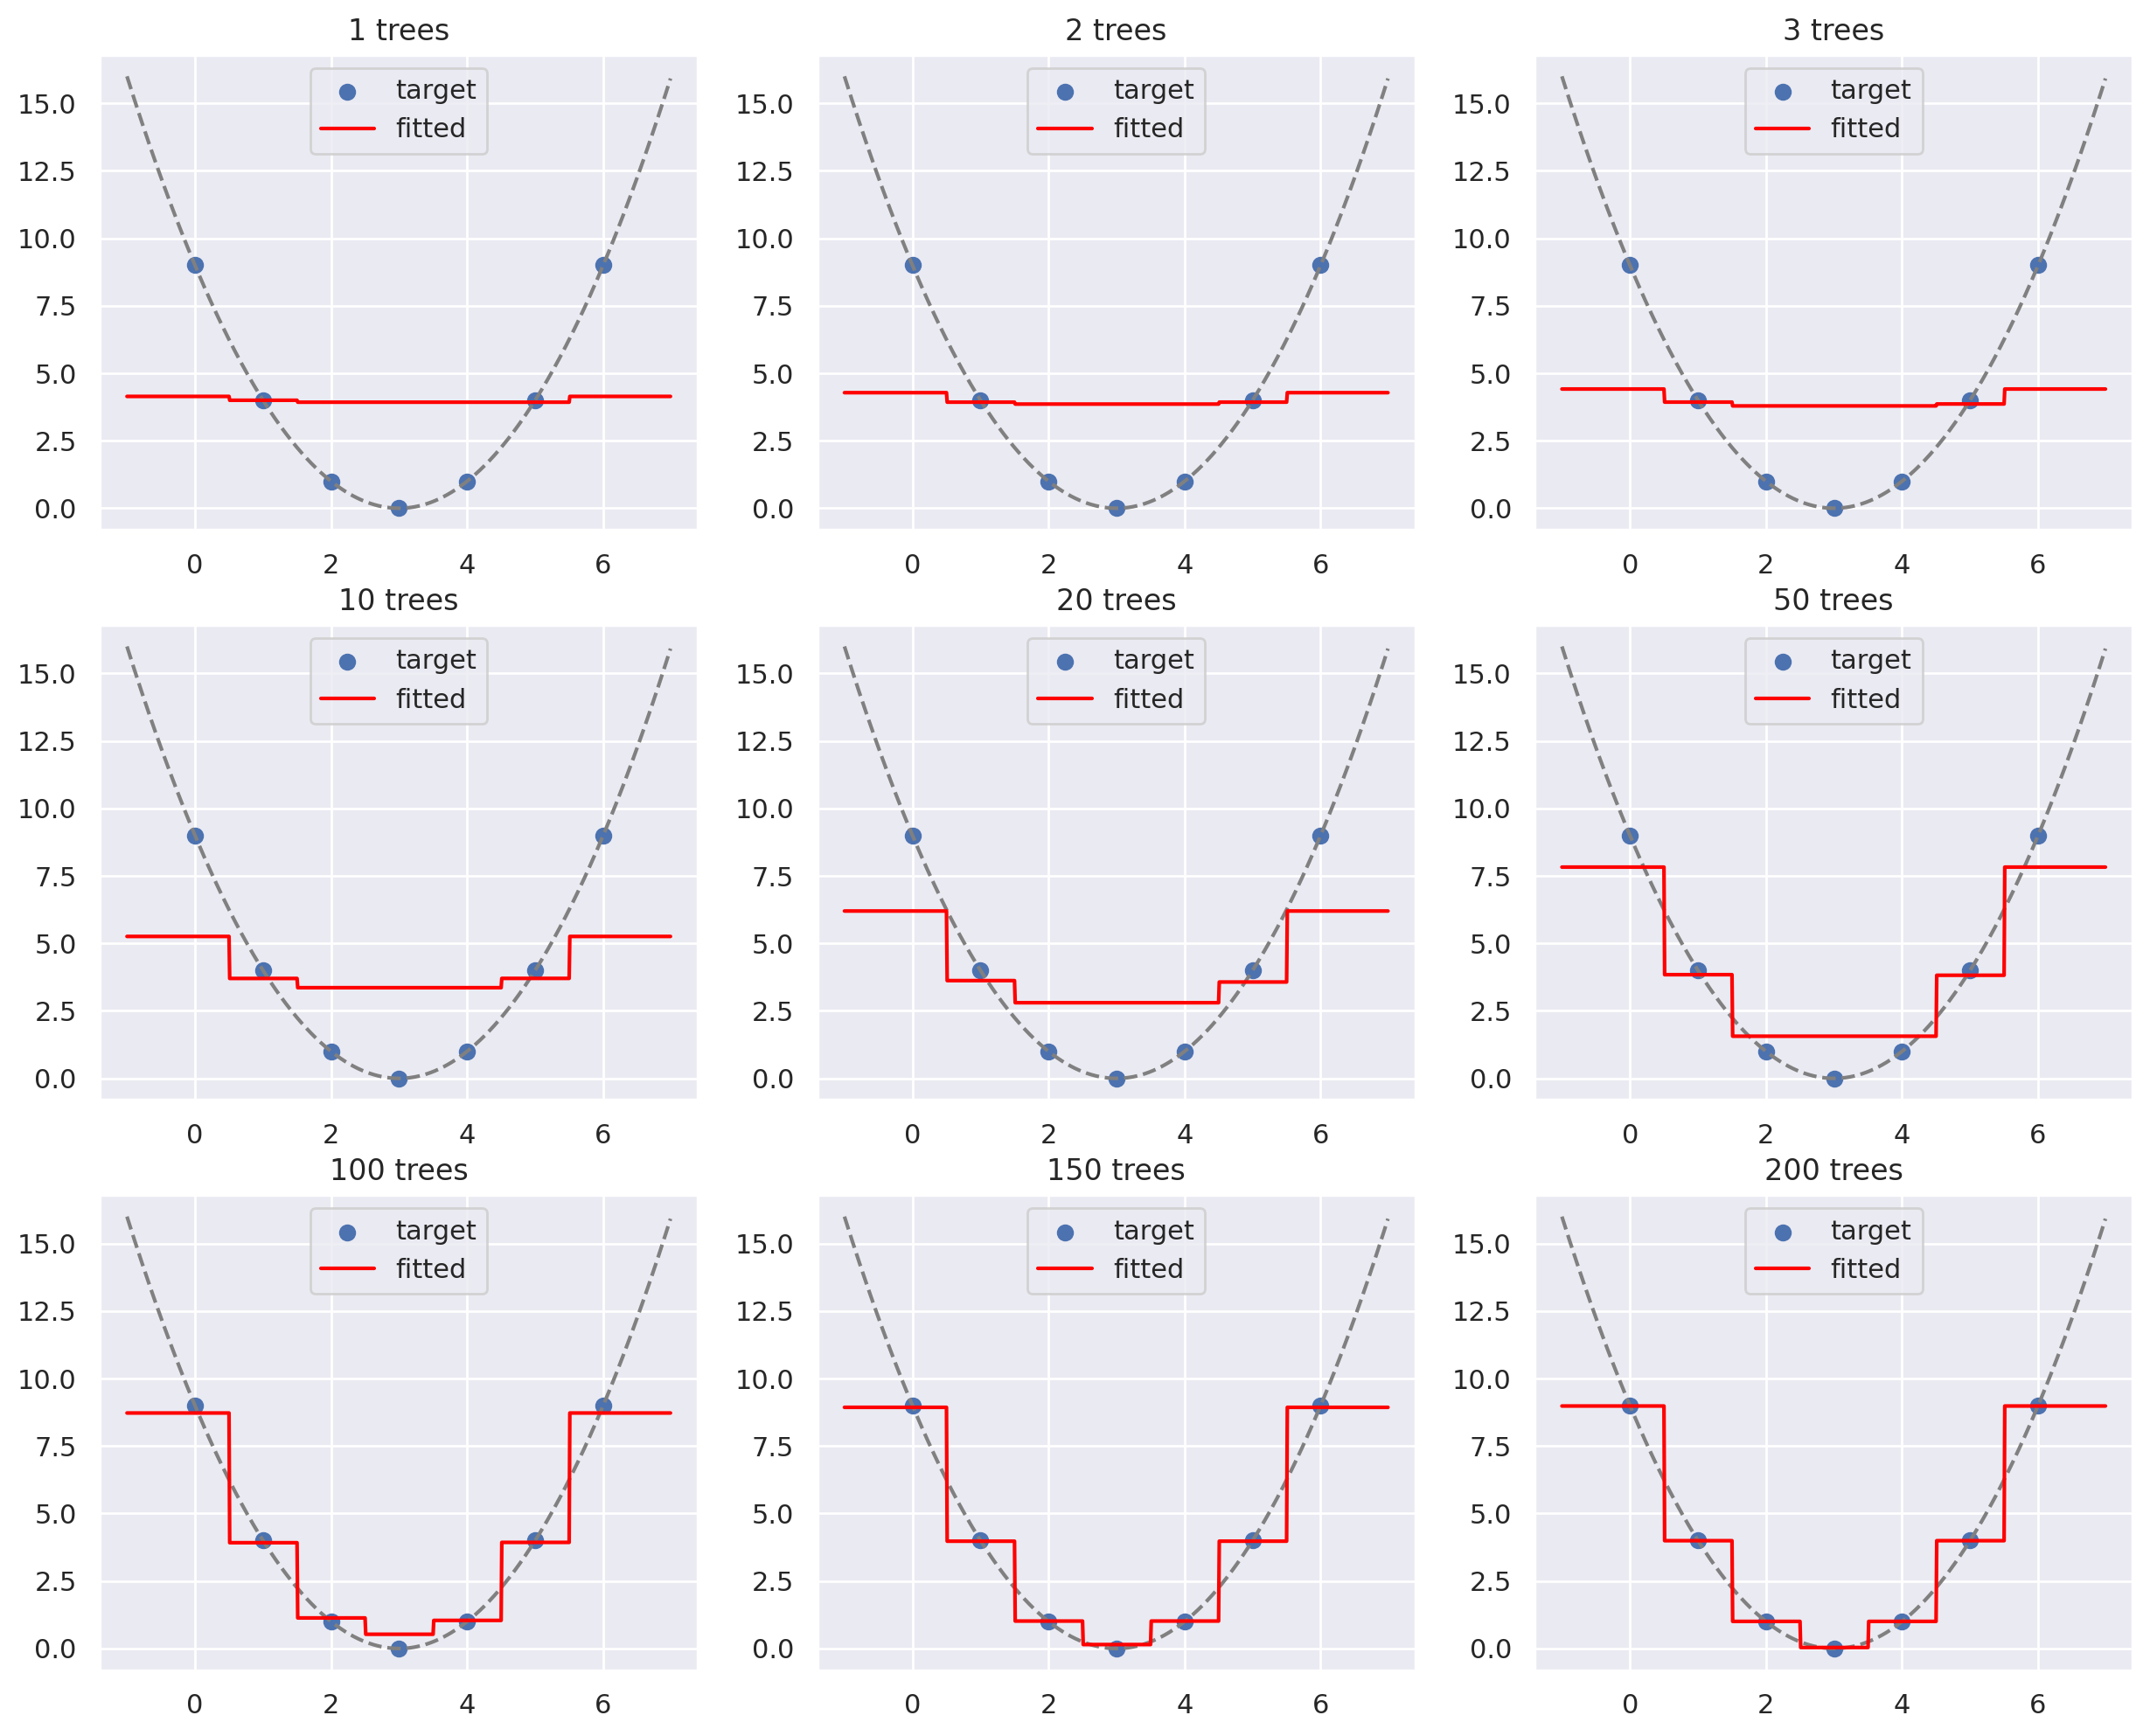

In [8]:
plt.subplots(3, 3)

for i, n_trees in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)

    gbr = GradientBoosting(
        n_estimators=n_trees,
        loss_name="mse",
        max_depth=3,
        learning_rate=0.1,
        debug=True,
    )
    gbr.fit(X_regr_toy, y_regr_toy)

    plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
    plt.scatter(X_regr_toy, y_regr_toy, label="target")
    plt.plot(
        xx,
        gbr.predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend()
    plt.title("%s trees" % str(n_trees));

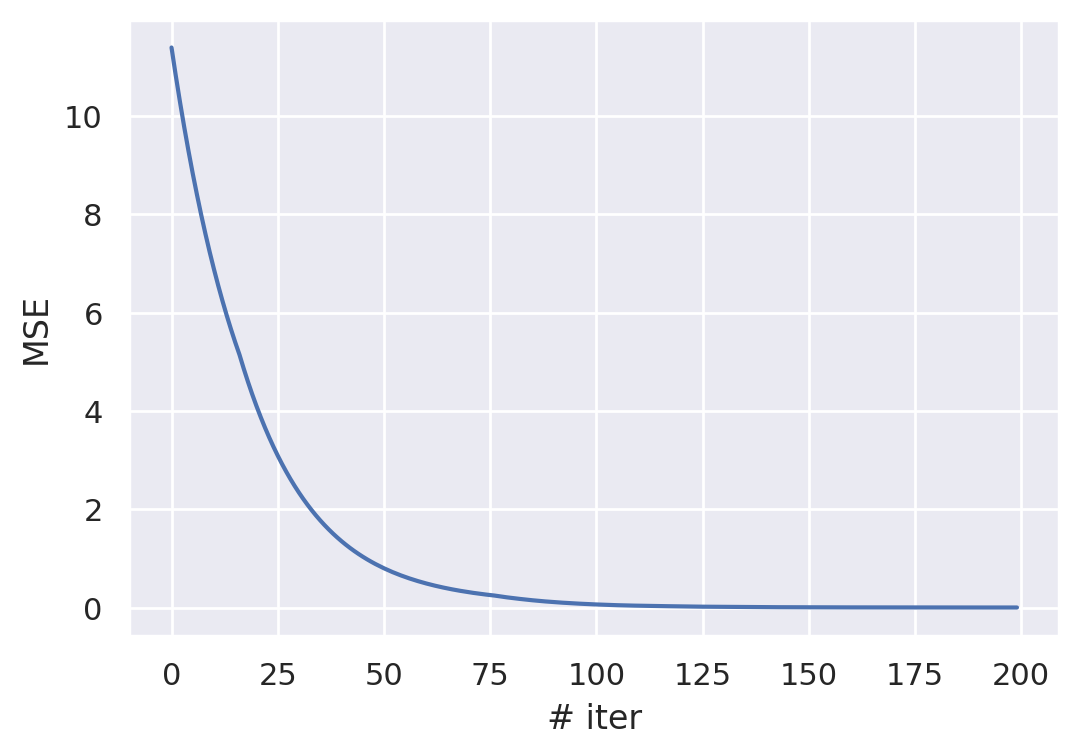

In [9]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(range(len(gbr_mse.loss_by_iter)), gbr_mse.loss_by_iter)
plt.xlabel("# iter")
plt.ylabel("MSE");

**Задание:**

Обучите еще один регрессор `GradientBoosting` с теми же входными параметрами, но измените функцию потерь на `RMSLE`. Постройте график с теми же значениями, что и в предыдущей задаче.

**Решение:**

In [10]:
gbr_rmsle = GradientBoosting(
    loss_name="rmsle",
    n_estimators=200,
    learning_rate=0.5,
    max_depth=3,
    debug=True
)
gbr_rmsle.fit(X_regr_toy, y_regr_toy)

  0%|          | 0/200 [00:00<?, ?it/s]

GradientBoosting(debug=True, learning_rate=0.5, loss_name='rmsle',
                 n_estimators=200)

  0%|          | 0/200 [00:00<?, ?it/s]

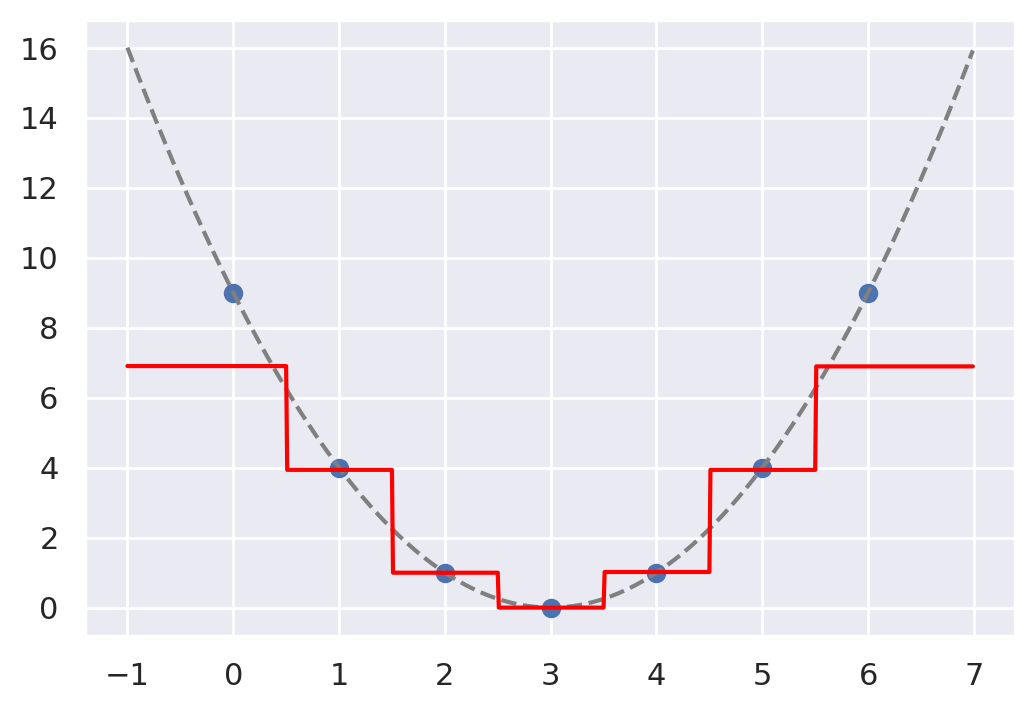

In [11]:
xx = get_1d_grid(X_regr_toy)
plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
plt.scatter(X_regr_toy, y_regr_toy)
plt.plot(xx, gbr_rmsle.predict(xx.reshape([xx.shape[0], 1])), color="red");

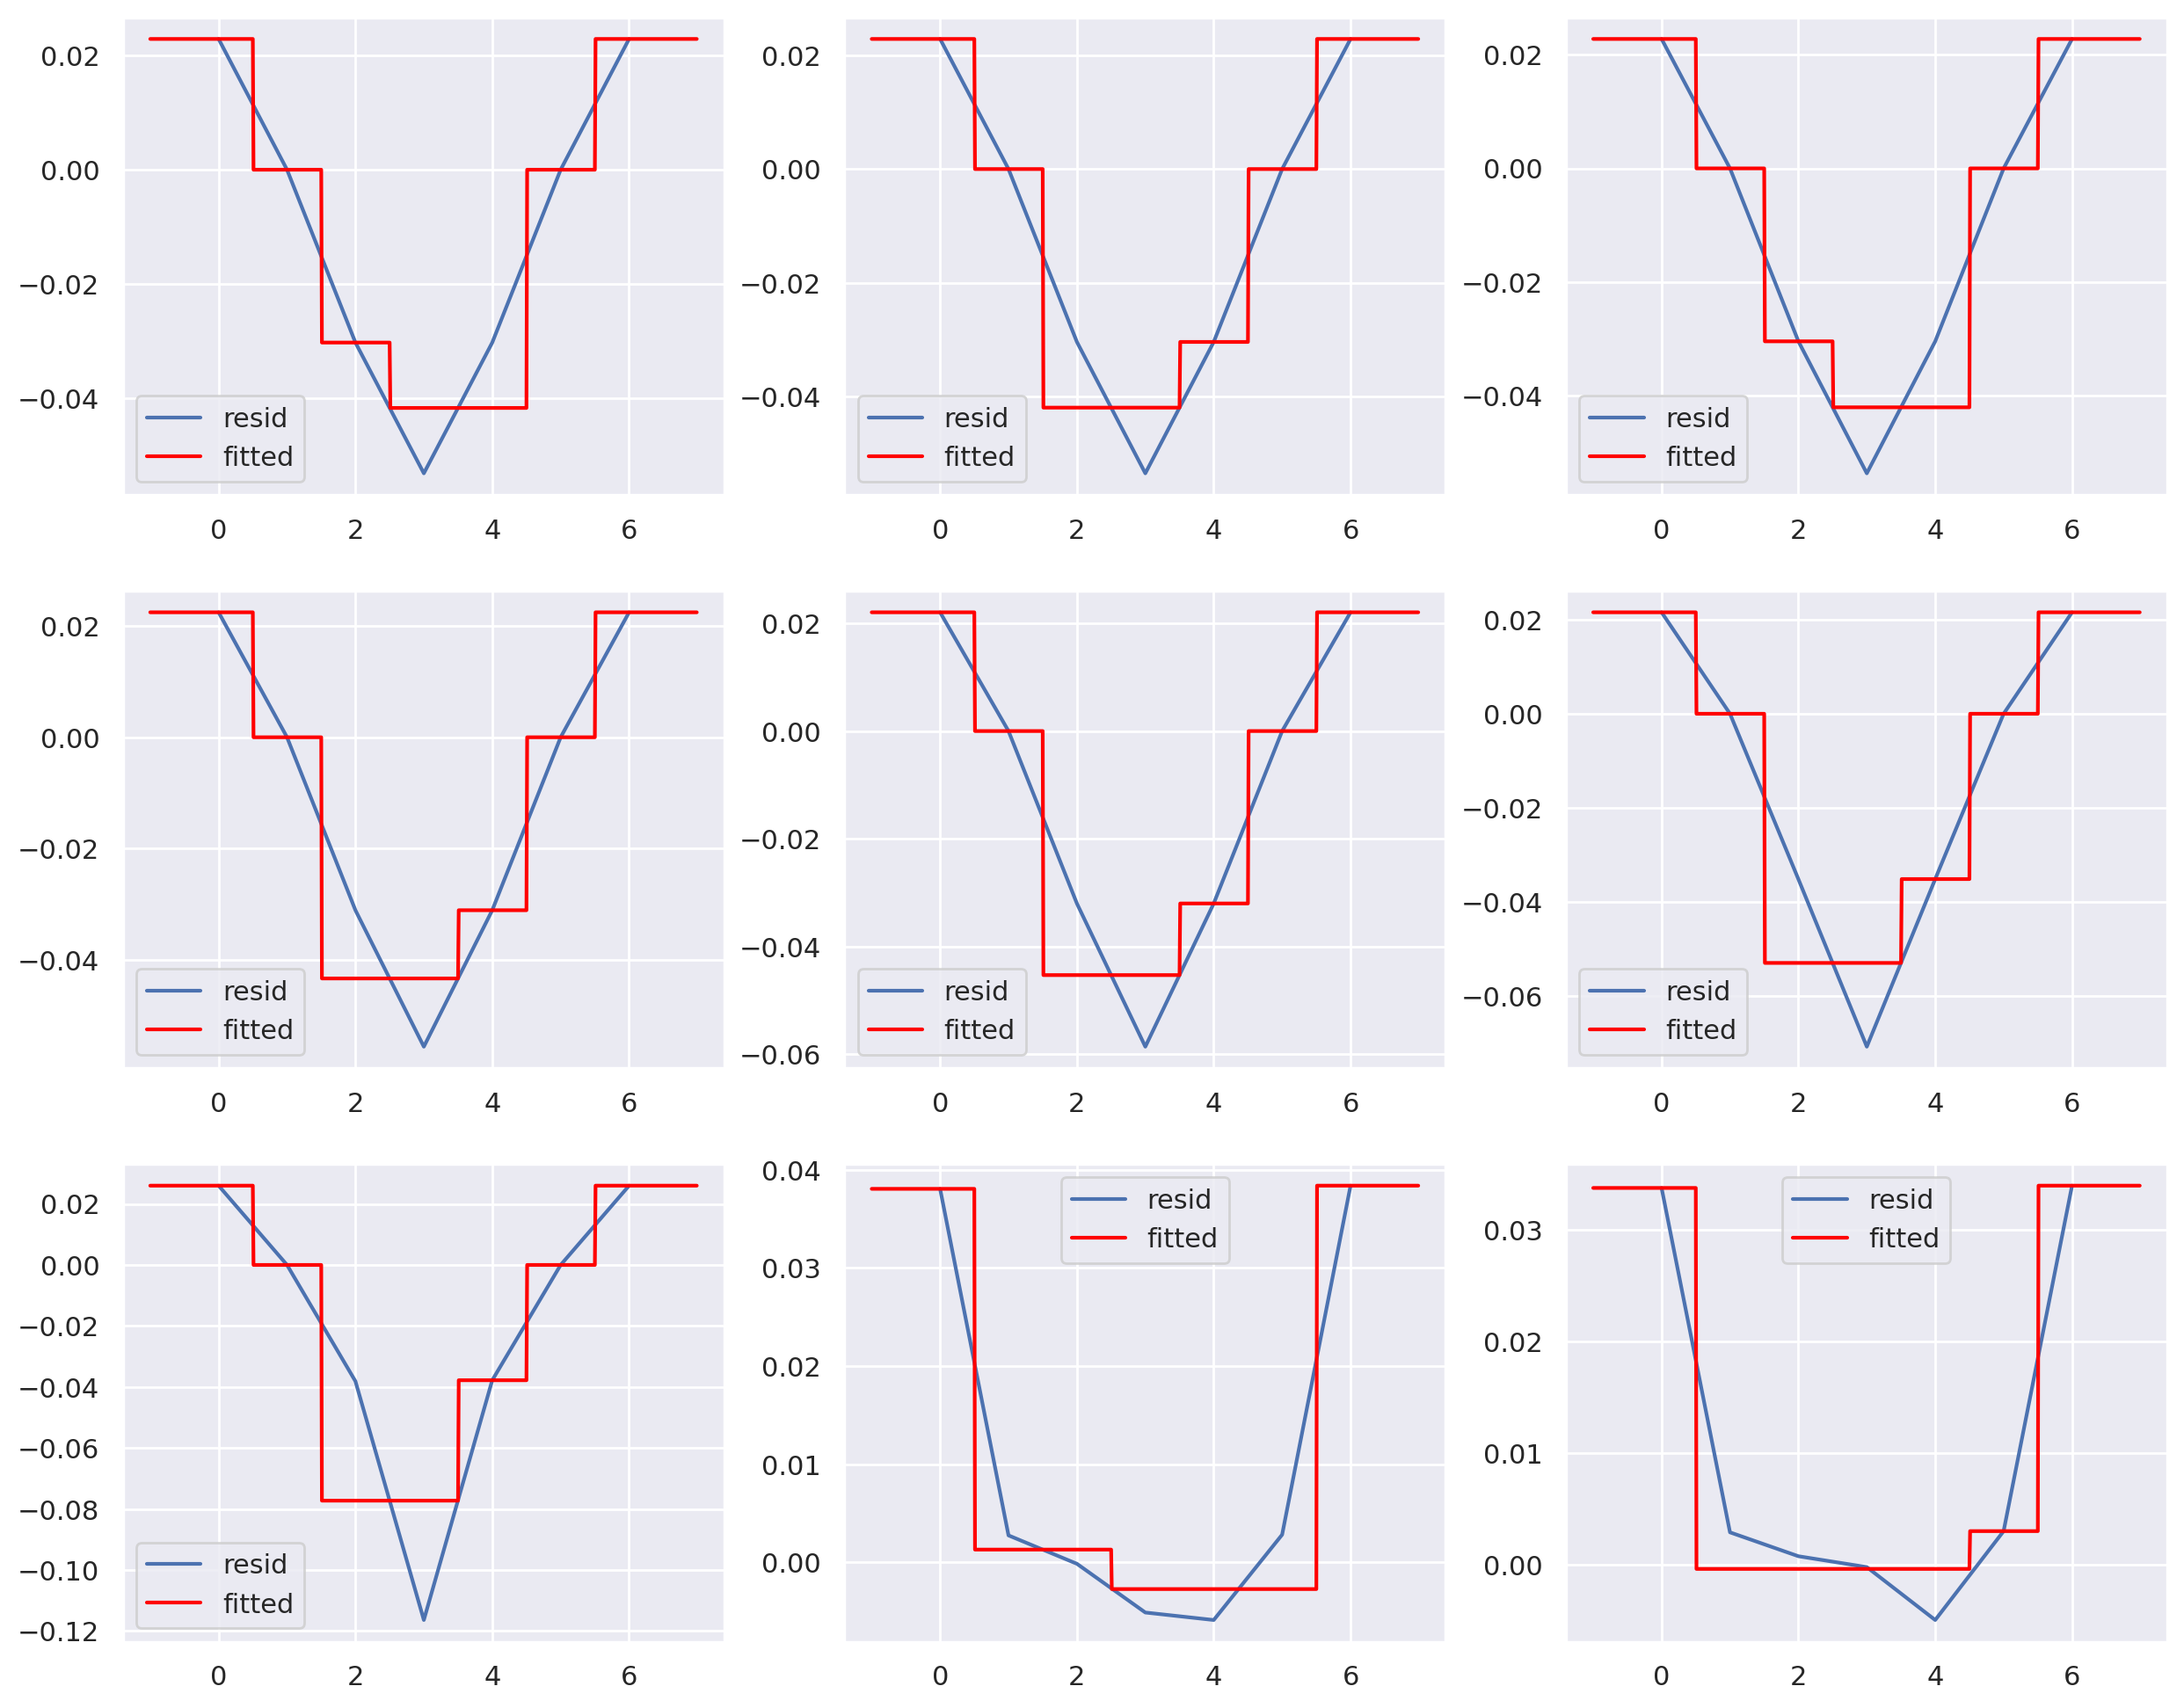

In [12]:
plt.rcParams["figure.figsize"] = (15, 12)

plt.subplots(3, 3)

for i, tree_idx in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    plt.plot(
        X_regr_toy,
        gbr_rmsle.residuals[tree_idx - 1],
        label="resid"
    )
    plt.plot(
        xx,
        gbr_rmsle.trees_[tree_idx - 1].predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend();

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

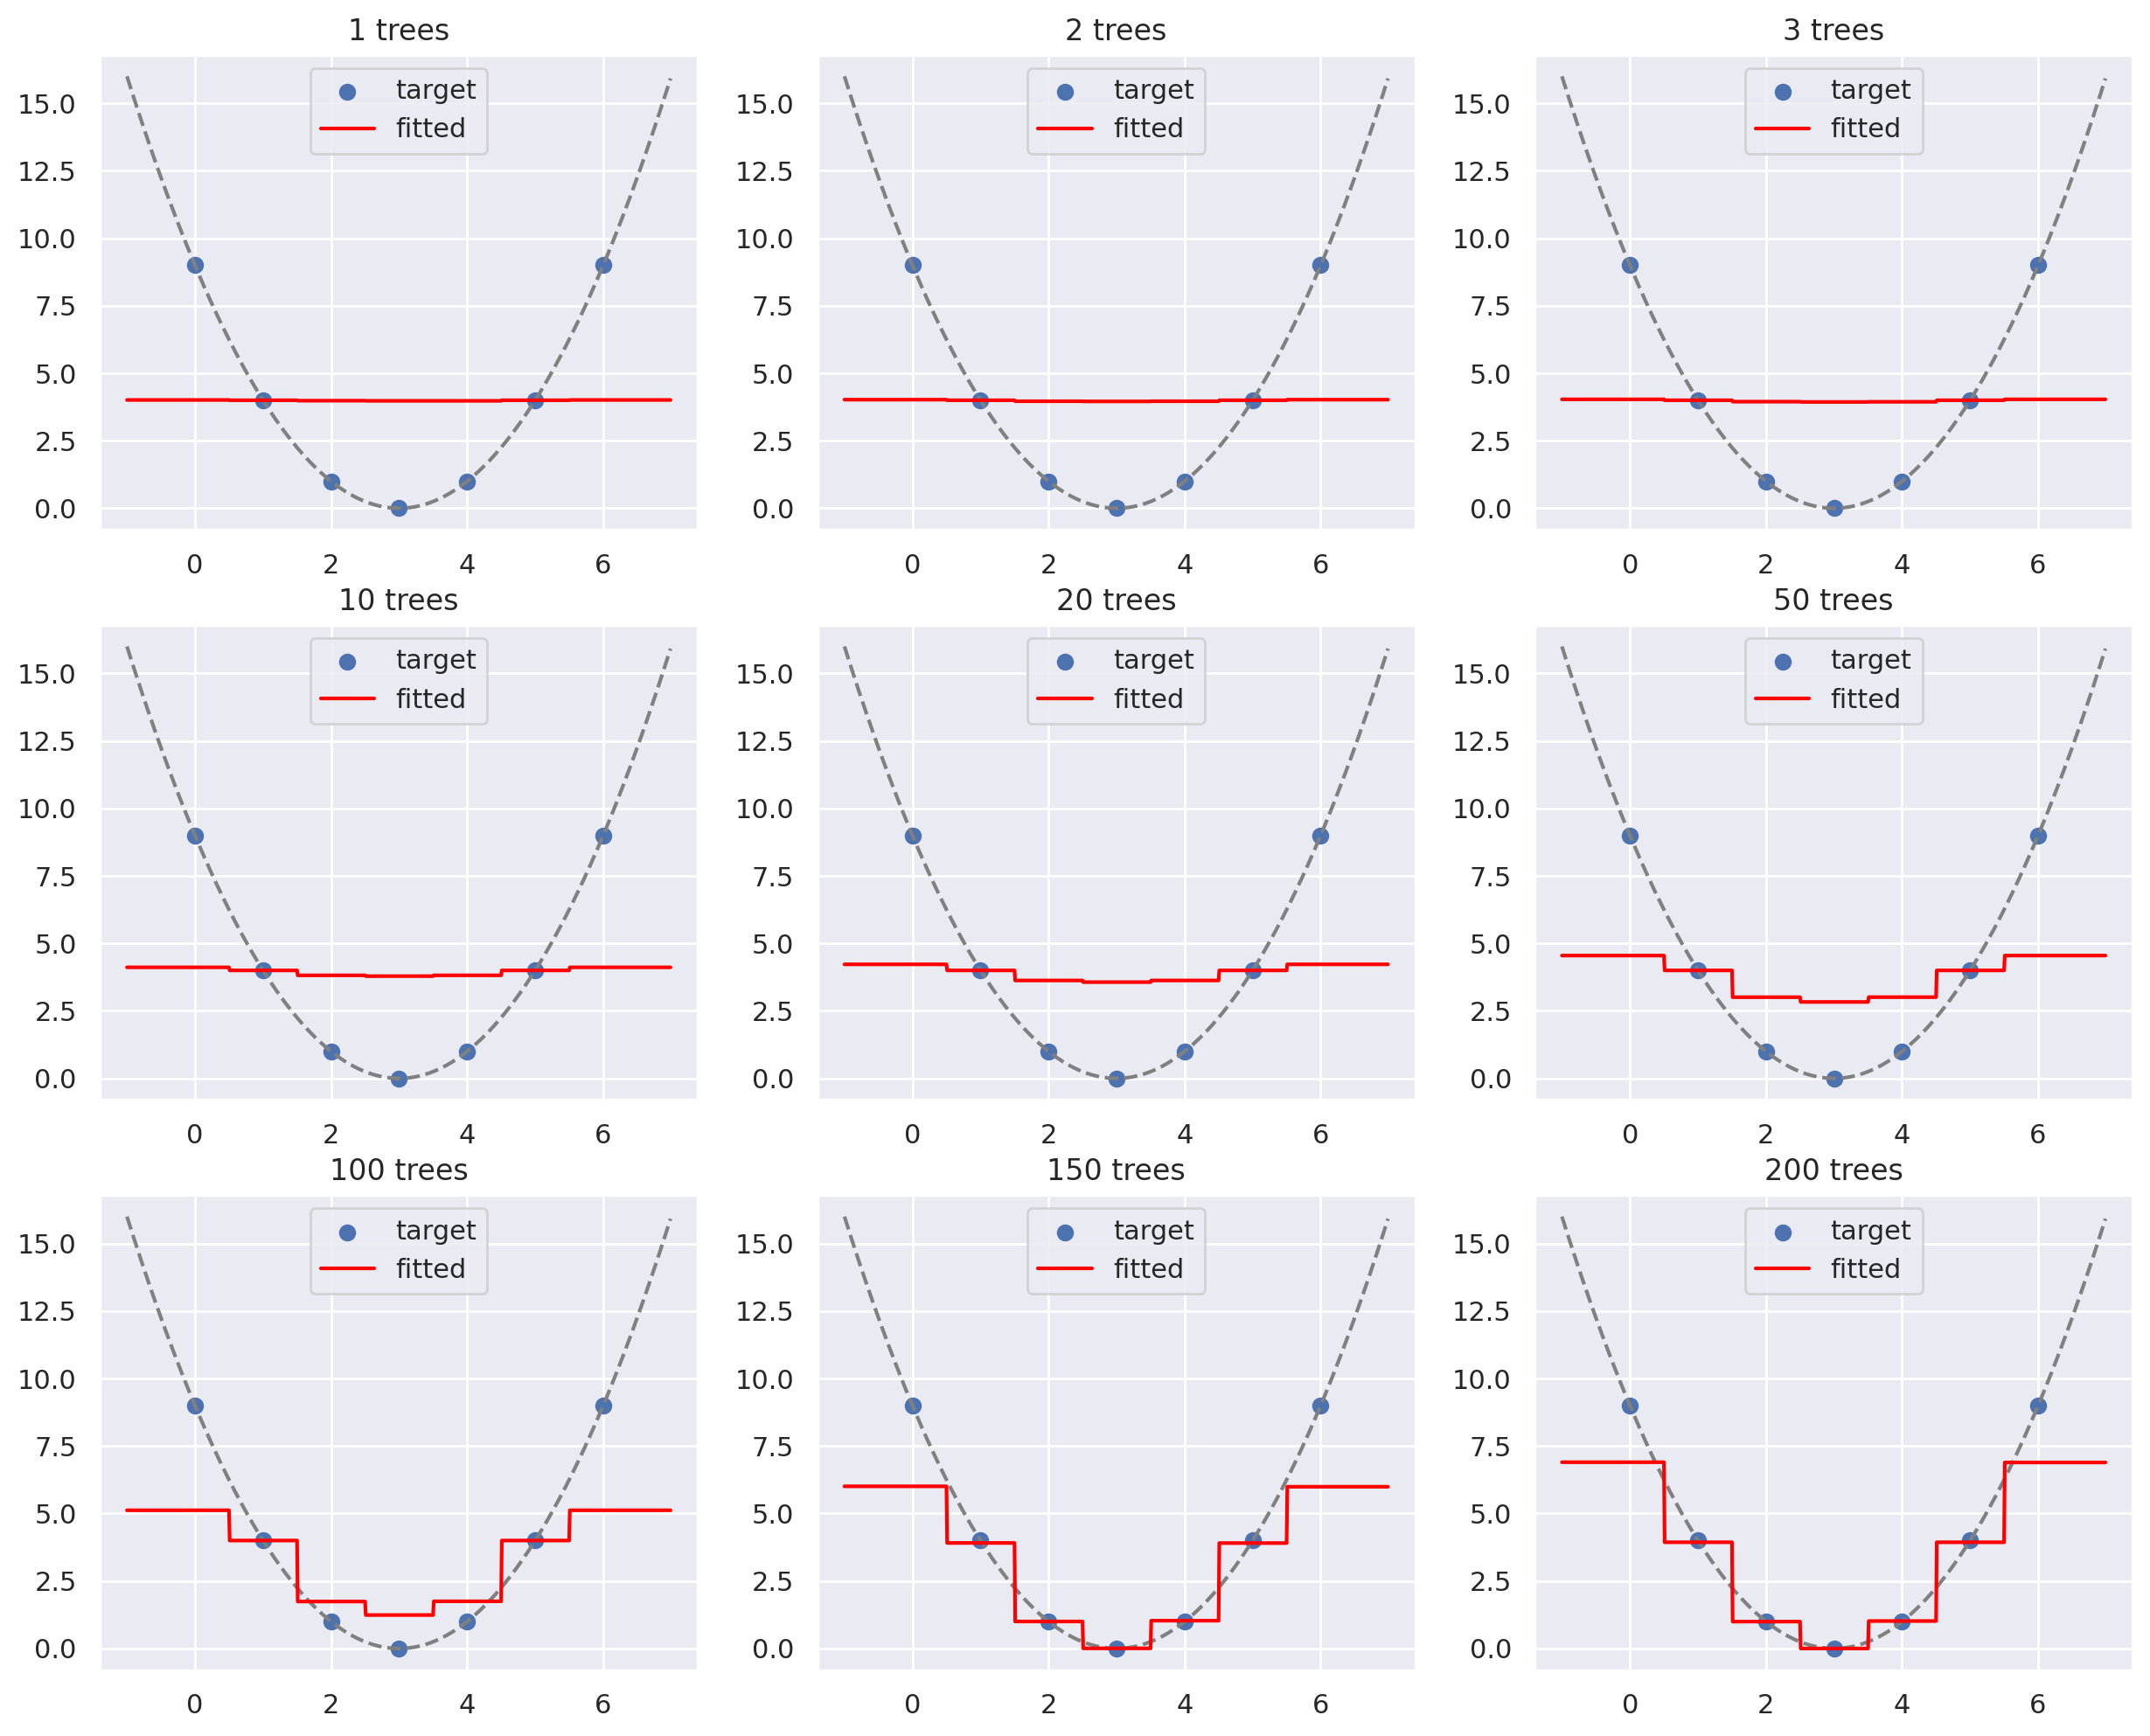

In [13]:
plt.subplots(3, 3)

for i, n_trees in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)

    gbr = GradientBoosting(
        n_estimators=n_trees, loss_name="rmsle", max_depth=3, learning_rate=0.5
    )
    gbr.fit(X_regr_toy, y_regr_toy)

    plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
    plt.scatter(X_regr_toy, y_regr_toy, label="target")
    plt.plot(
        xx,
        gbr.predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend()
    plt.title("%s trees" % str(n_trees));

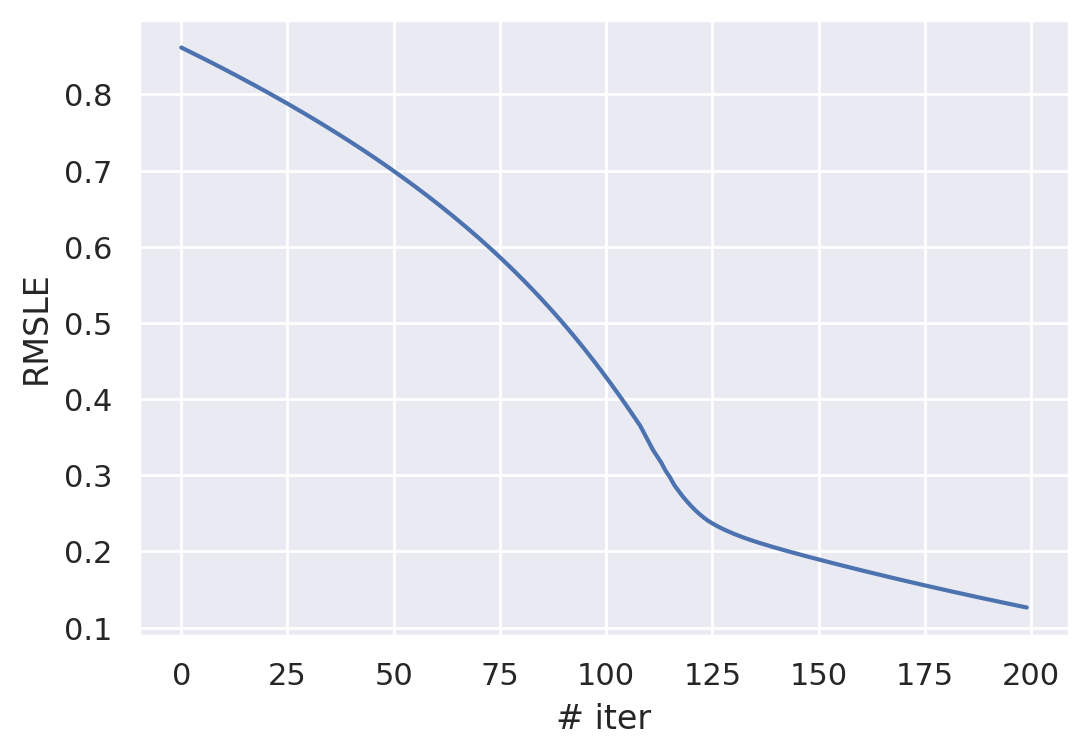

In [14]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(range(len(gbr_rmsle.loss_by_iter)), gbr_rmsle.loss_by_iter)
plt.xlabel("# iter")
plt.ylabel("RMSLE");

## Классификация на игрушечном примере

Подготовьте набор данных:

In [15]:
X_clf_toy = np.c_[np.arange(7), (np.arange(7) - 3) ** 2]
y_clf_toy = np.array([0, 1, 0, 1, 0, 1, 0])

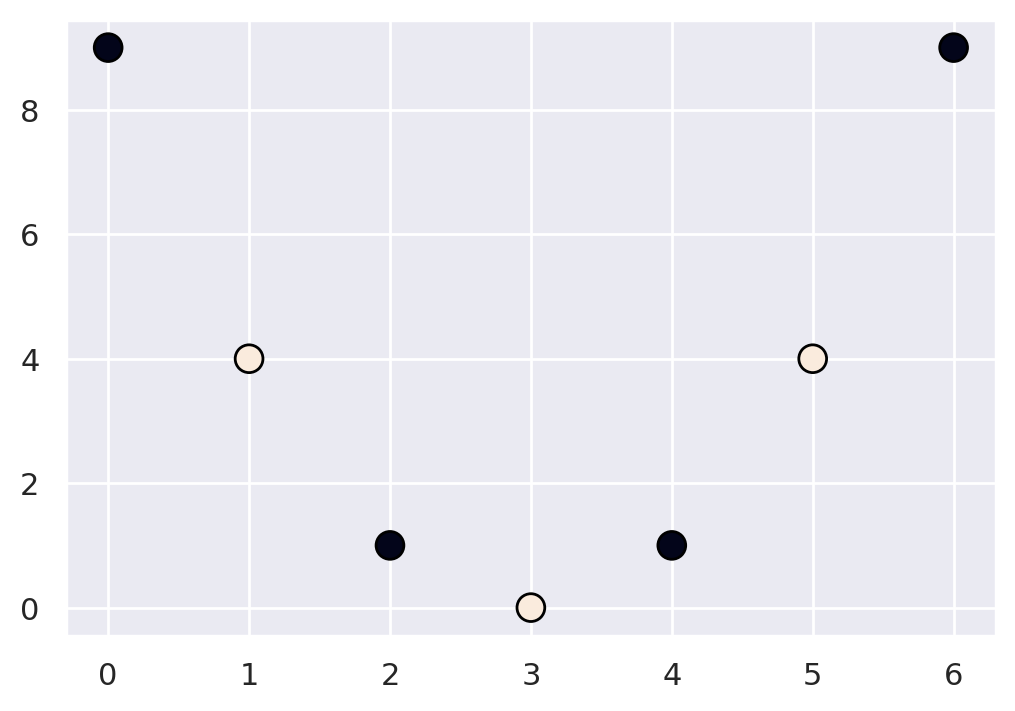

In [16]:
plt.scatter(
    X_clf_toy[:, 0],
    X_clf_toy[:, 1],
    c=y_clf_toy,
    s=100,
    edgecolors="black",
    linewidth=1,
);

**Задание:**

Обучите классификатор типа `GradientBoosting` с функцией потерь `log_loss` и следующими параметрами: `learning_rate=0.05`, `max_depth=3`, `n_estimators=10`. Затем постройте график изменения функции потерь за итерации бустинга. Можно также визуализировать начальное приближение и псевдоостатки на первых итерациях, как это сделано в статье.

**Решение:**

In [17]:
gbclf = GradientBoosting(
    loss_name="log_loss",
    n_estimators=10,
    learning_rate=0.05,
    max_depth=3
)
gbclf.fit(X_clf_toy, y_clf_toy)

  0%|          | 0/10 [00:00<?, ?it/s]

GradientBoosting(learning_rate=0.05, loss_name='log_loss')

In [18]:
pred_propbs = gbclf.predict_proba(X_clf_toy)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

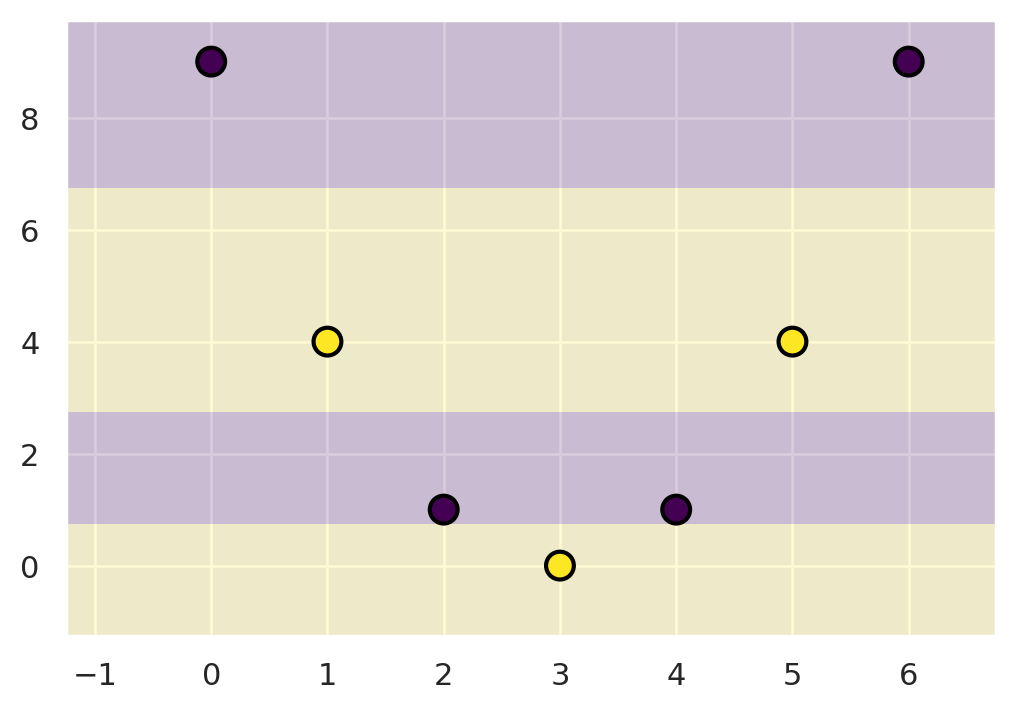

In [19]:
xx, yy = get_2d_grid(X_clf_toy, eps=0.5)
predicted = gbclf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="viridis", alpha=0.2, shading="auto")
plt.scatter(
    X_clf_toy[:, 0],
    X_clf_toy[:, 1],
    c=y_clf_toy,
    s=100,
    cmap="viridis",
    edgecolors="black",
    linewidth=1.5,
);

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

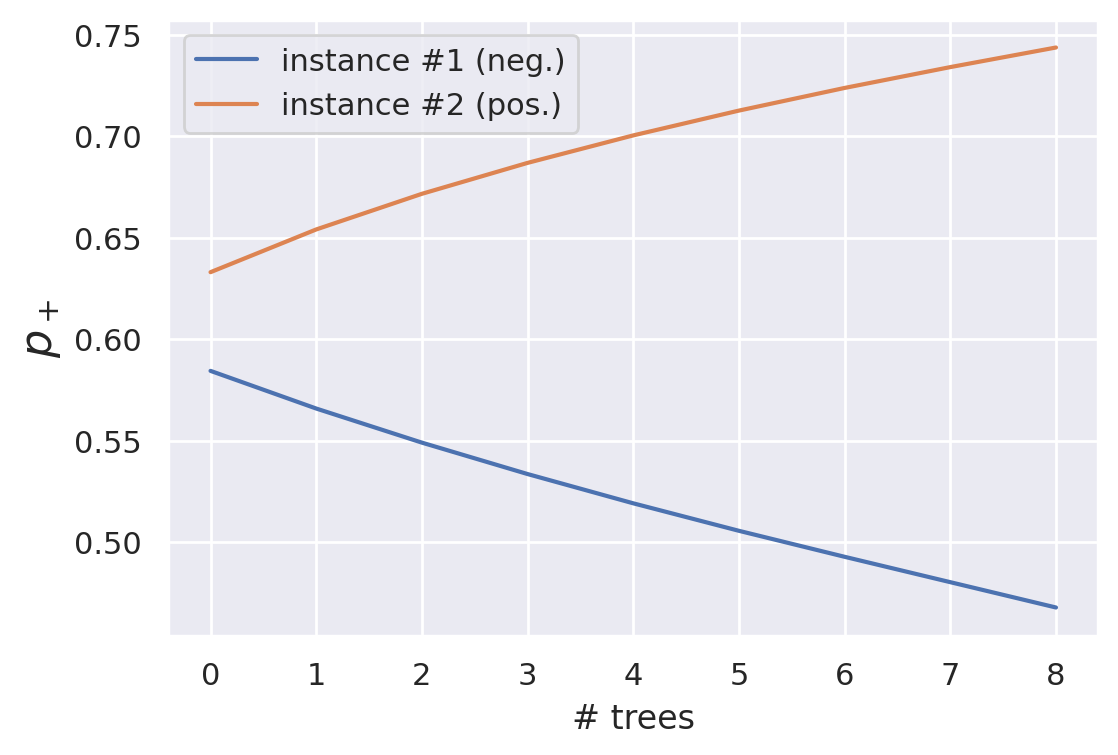

In [20]:
plt.rcParams["figure.figsize"] = (6, 4)

pred_probs1_by_tree, pred_probs2_by_tree = [], []

for i in range(9):
    gbclf_ = GradientBoosting(
        n_estimators=i + 1, loss_name="log_loss", max_depth=3, learning_rate=0.05
    ).fit(X_clf_toy, y_clf_toy)
    pred_probs1_by_tree.append(gbclf_.predict_proba(X_clf_toy)[0])
    pred_probs2_by_tree.append(gbclf_.predict_proba(X_clf_toy)[1])
plt.plot(pred_probs1_by_tree, label="instance #1 (neg.)")
plt.plot(pred_probs2_by_tree, label="instance #2 (pos.)")
plt.xlabel("# trees")
plt.ylabel(r"$p_+$", fontsize=16)
plt.legend();

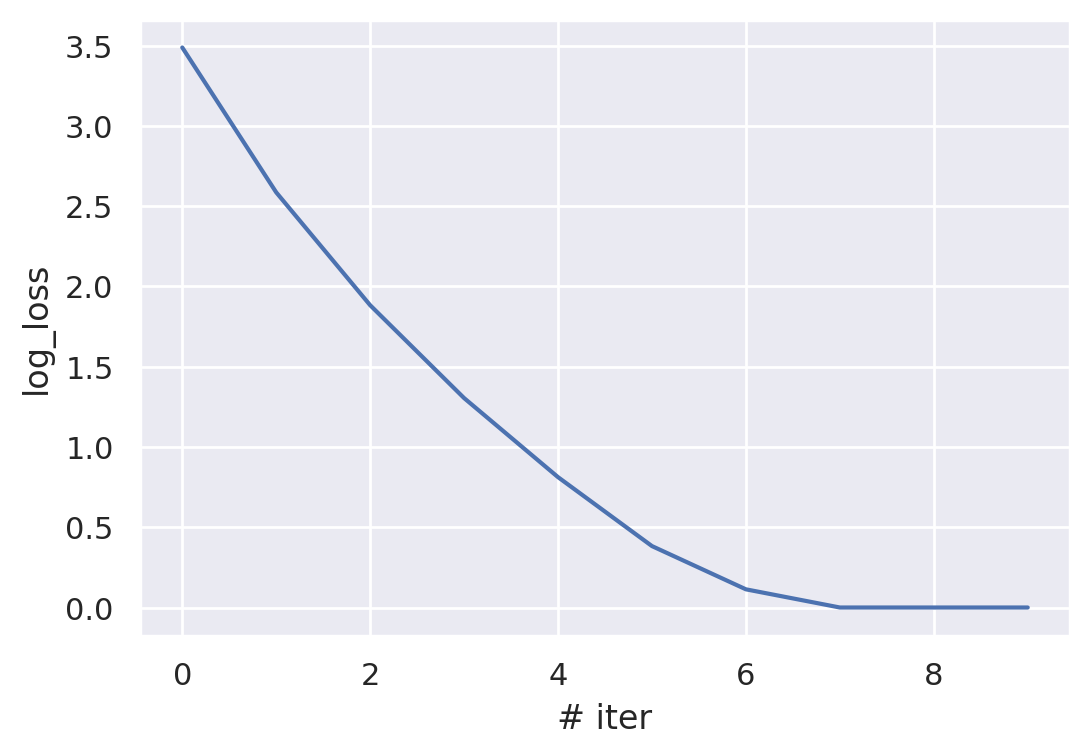

In [21]:
plt.plot(range(len(gbclf.loss_by_iter)), gbclf.loss_by_iter)
plt.xlabel("# iter")
plt.ylabel("log_loss");

**Вопрос 4. Для всех примеров $7$ в игрушечном наборе данных вычислить предсказанные вероятности отнесения к классу $+1$? Каковы два уникальных значения в вычисленном векторе?**

1. $0.42$ и $0.77$
2. $0.36$ и $0.82$
3. $0.48$ и $0.53$
4. $0.46$ и $0.75$

**Ответ:** 4.

In [22]:
np.unique(pred_propbs)

array([0.45554883, 0.75303888])

## Регрессия с использованием набора данных Boston House-Prices

Подготовьте набор данных:

In [23]:
import pandas as pd

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

X, y = data, target

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

**Задание:**

- Обучить регрессор `GradientBoosting` с функцией потерь `MSE` и следующими параметрами: `learning_rate=3`, `max_depth=10`, `n_estimators=300`.
- Построить график изменения функции потерь за итерации бустинга.
- Выполнить прогнозирование на тестовом множестве.
- Постройте распределение `y_test`, представляющее собой значения выходных переменных из обучающего набора, и распределение `test_pred`, содержащее значения, предсказанные градиентным бустингом. Используйте метод `hist` из `matplotlib.pyplot` с параметром `bins=15`.

**Решение:**

In [25]:
regr = GradientBoosting(
    loss_name="mse", n_estimators=300, max_depth=10, learning_rate=3
)

regr.fit(X_train, y_train)

  0%|          | 0/300 [00:00<?, ?it/s]

GradientBoosting(learning_rate=3, max_depth=10, n_estimators=300)

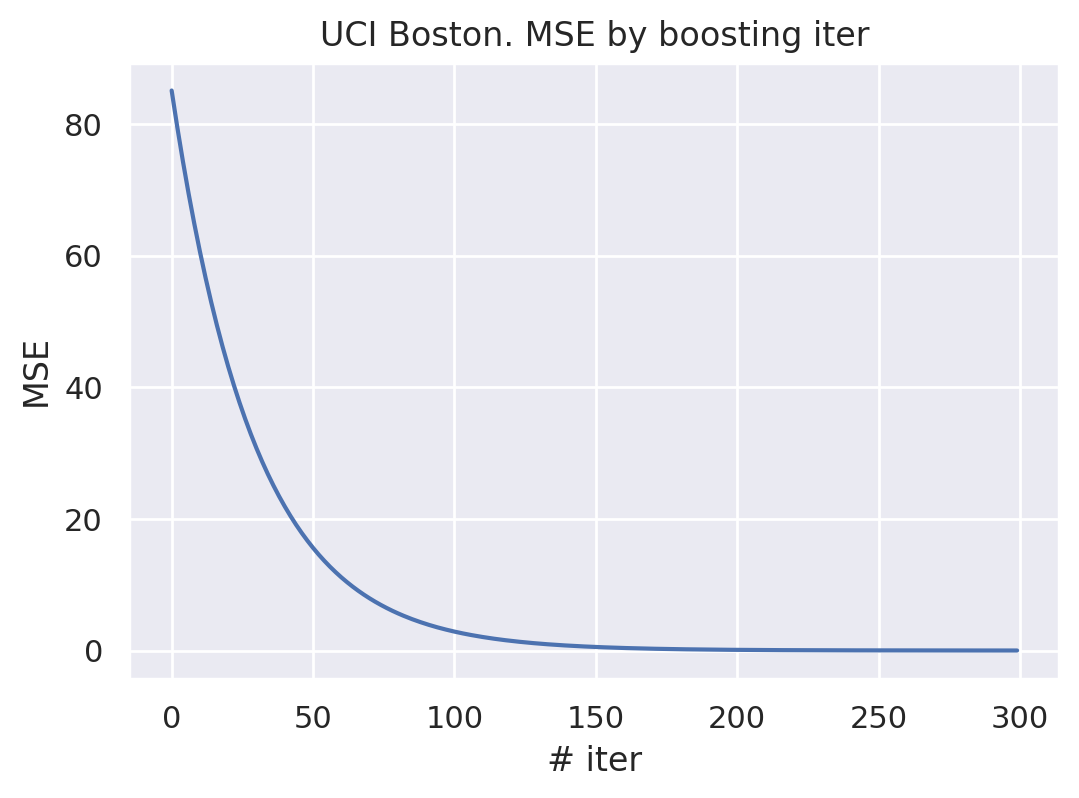

In [26]:
plt.plot(range(len(regr.loss_by_iter)), regr.loss_by_iter)
plt.xlabel("# iter")
plt.ylabel("MSE")
plt.title("UCI Boston. MSE by boosting iter");

  0%|          | 0/300 [00:00<?, ?it/s]

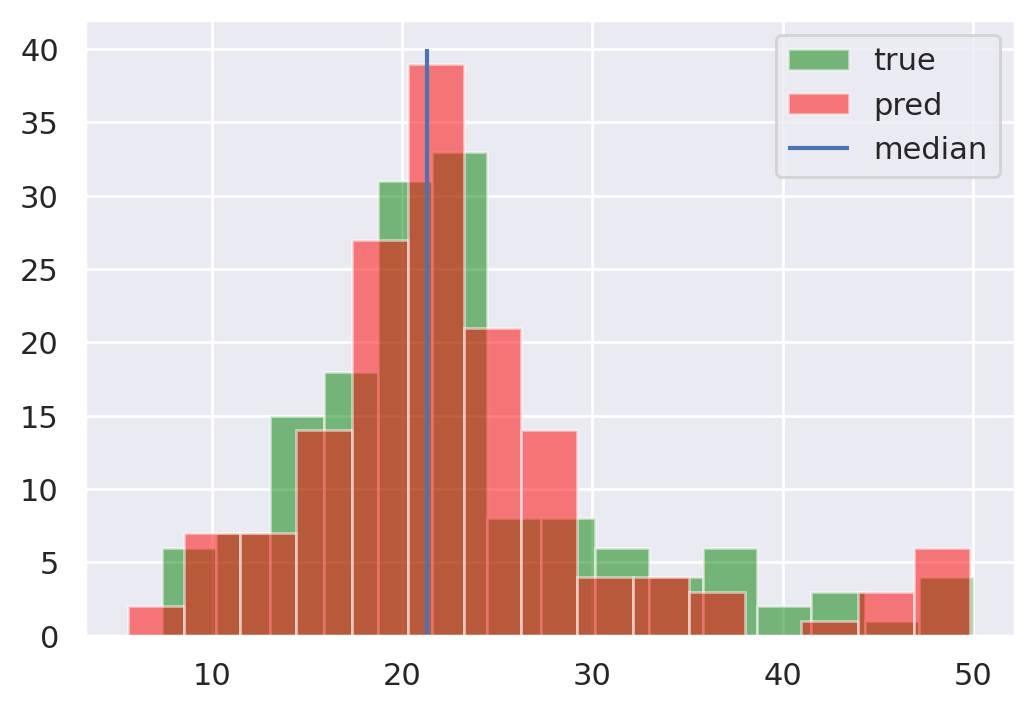

In [27]:
plt.hist(y_test, alpha=0.5, color="green", label="true", bins=15)
plt.hist(regr.predict(X_test), alpha=0.5, color="red", label="pred", bins=15)
plt.vlines(x=np.median(y_test), ymin=0, ymax=40, label="median")
plt.legend();

**Вопрос 5. Выберите правильное утверждение относительно полученных гистограмм:**
1. В среднем прогнозы, полученные с помощью бустинга, завышаются на 10.
2. В бине, содержащем медиану ответов на тестовом наборе (т.е. `numpy.median(y_test)`), больше значений из вектора предсказаний `test_pred`, чем из вектора ответов `y_test`.
3. Иногда наш алгоритм boosting предсказывает значения, которые находятся далеко за пределами диапазона вектора `y_test`.

**Ответ:** 2.

## Классификация на основе набора данных Breast Cancer Wisconsin

Подготовьте набор данных:

In [28]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

**Задание:**

- Обучить классификатор `GradientBoosting` с функцией потерь `log_loss` и параметрами `learning_rate=0.01`, `max_depth=3`, `n_estimators=200`.
- Построить график изменения функции потерь за итерации бустинга.
- Сделать предсказания на тестовом множестве: как вероятности попадания в класс $+1$, так и бинарные предсказания. 
- Рассчитать ROC AUC для случая вероятностей и долю правильных ответов для бинарных предсказаний.

**Решение:**

In [30]:
clf = GradientBoosting(
    loss_name="log_loss",
    learning_rate=0.01,
    max_depth=3,
    n_estimators=200,
)
clf.fit(X_train, y_train)

  0%|          | 0/200 [00:00<?, ?it/s]

GradientBoosting(loss_name='log_loss', n_estimators=200)

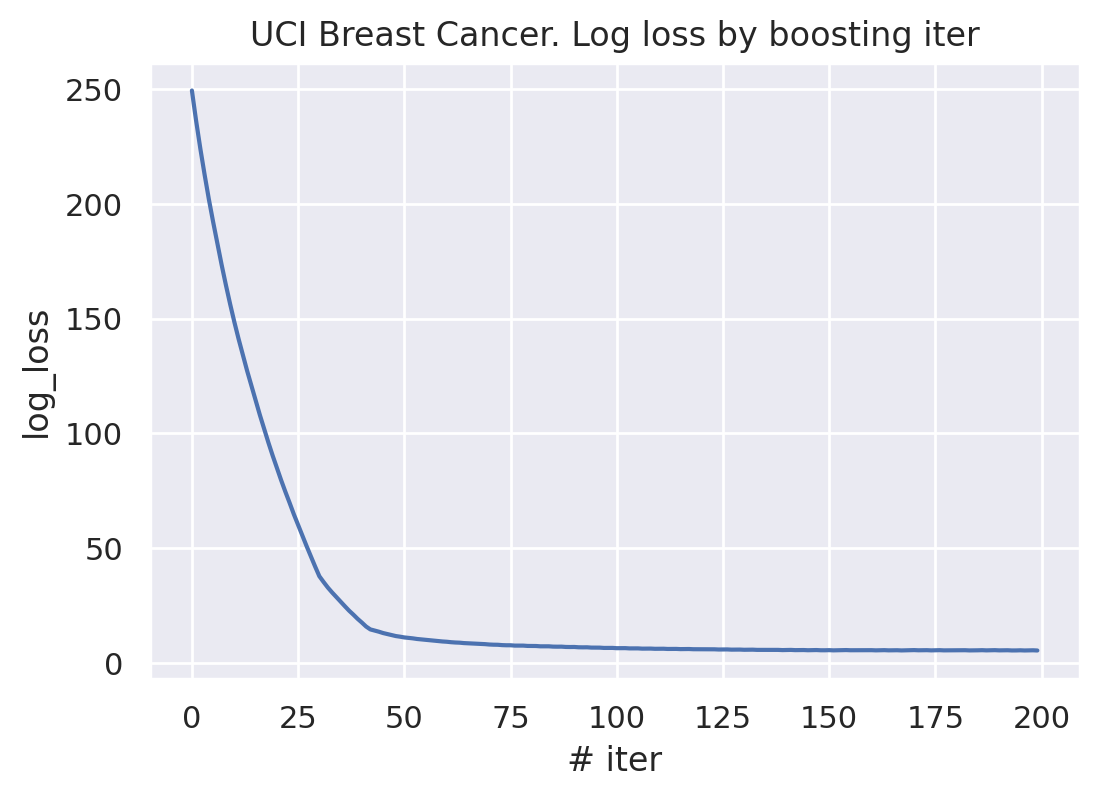

In [31]:
plt.plot(range(len(clf.loss_by_iter)), clf.loss_by_iter)
plt.xlabel("# iter")
plt.ylabel("log_loss")
plt.title("UCI Breast Cancer. Log loss by boosting iter");

In [32]:
pred_probs = clf.predict_proba(X_train)

  0%|          | 0/200 [00:00<?, ?it/s]

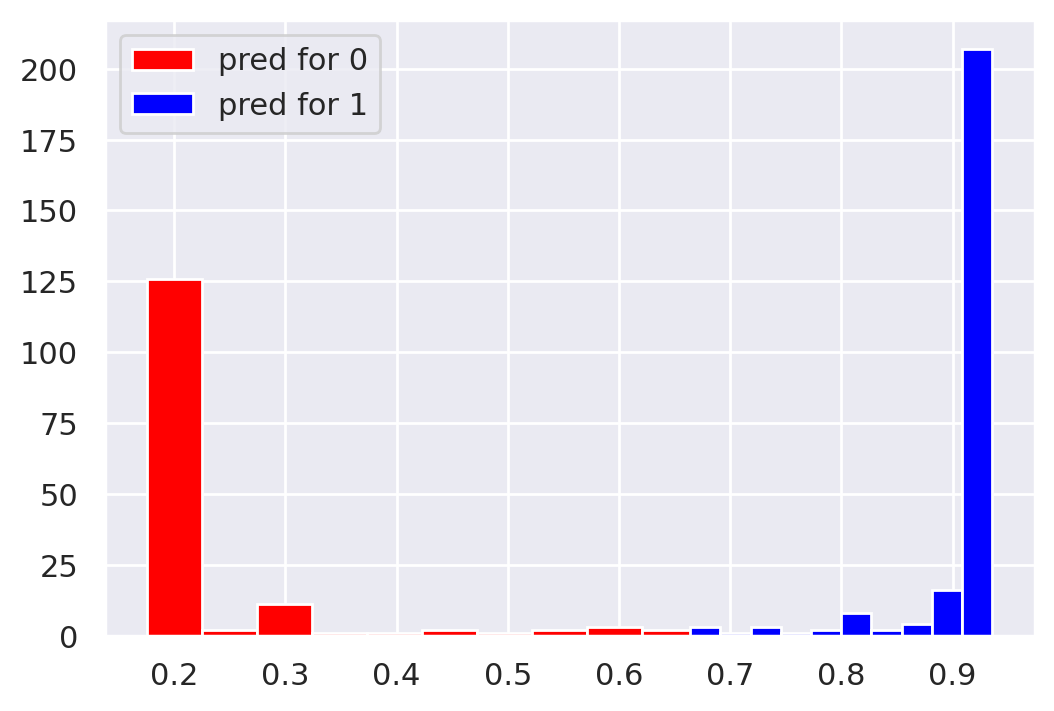

In [33]:
plt.hist(pred_probs[y_train == 0], color="red", label="pred for 0")
plt.hist(pred_probs[y_train == 1], color="blue", label="pred for 1")
plt.legend();

In [34]:
roc_auc_score(y_test, clf.predict_proba(X_test)), accuracy_score(
    y_test, clf.predict(X_test)
)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(0.9885245901639345, 0.9707602339181286)

**Вопрос 6. Каковы значение ROC AUC и доля правильных предсказаний на тестовом множестве `(X_test, y_test)`?**
1. $0.99$ и $0.97$
2. $1$ и $0.97$
3. $0.98$ и $0.96$
4. $0.97$ и $0.95$

**Ответ:** 1.